# Color quantization & first evaluation of color histogram classifier

## Loading the data

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from ipywidgets import interact
import ipywidgets as widgets

from dobble_master_race.toolkit import get_data_set

In [3]:
X, Y = get_data_set()
X.shape, Y.shape

((285,), (285,))

## What the data looks like ?

In [4]:
nb_class = np.max(Y)
X_old = X.copy()

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, x in enumerate(X_old[Y == class_]):
        ax_arr[i].imshow(x)

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Apply median filter to reduce imperfections

In [5]:
X = np.array([cv2.medianBlur(img, 3, 0) for img in X], dtype=object)

## What the data looks like ?

In [6]:
nb_class = np.max(Y)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, x in enumerate(X[Y == class_]):
        ax_arr[i].imshow(x)

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

# Color reduction

## Better Image mask

On prend en compte tous les pixels à l'intérieur des formes

In [42]:
from dobble_master_race.img_utils import mask_with_inner

masks = np.array([mask_with_inner(img, 240) for img in X], dtype=object)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, mask in enumerate(masks[Y == class_]):
        ax_arr[i].imshow(mask, cmap='gray')

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Sampling pixels

In [8]:
nb_sample = 50000

nb_images = nb_class * 5
nb_sample_per_image = nb_sample // nb_images

sample_pxls = X[0][masks[0]][0] # Initialize arbitrary to be able to use np.vstack
for img, mask in zip(X[1:], masks[1:]):
    pxls = img[mask]
    new_sample_pxls_id = np.random.choice(pxls.shape[0], size=nb_sample_per_image, replace=False)
    sample_pxls = np.vstack((sample_pxls, pxls[new_sample_pxls_id]))

sample_pxls.shape, sample_pxls.dtype

((49701, 3), dtype('uint8'))

## Visualize sampled pixels

<IPython.core.display.Javascript object>


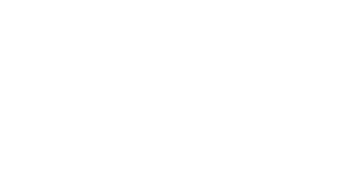

In [9]:
%matplotlib notebook

ax = plt.axes(projection="3d")

disp_pxls = sample_pxls[np.random.choice(sample_pxls.shape[0], size=10000, replace=False)]
ax.scatter3D(disp_pxls[:, 0], disp_pxls[:, 1], disp_pxls[:, 2], c = disp_pxls / 255)

plt.show()

In [10]:
%matplotlib inline

## Selecting color quantization threshold

In [11]:
from sklearn.cluster import KMeans
from tqdm import tqdm

# How to choose the right number of colors ?

inertias = []
new_colors = []
color_range = (2, 20)

# Compute new_colors and inertias
for i in tqdm(range(*color_range)):
    kmeans = KMeans(n_clusters=i, random_state=42)
    
    kmeans.fit(sample_pxls)
    inertias.append(kmeans.inertia_)
    
    new_color = kmeans.cluster_centers_.astype(np.uint8)
    new_colors.append(new_color)

100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.94it/s]


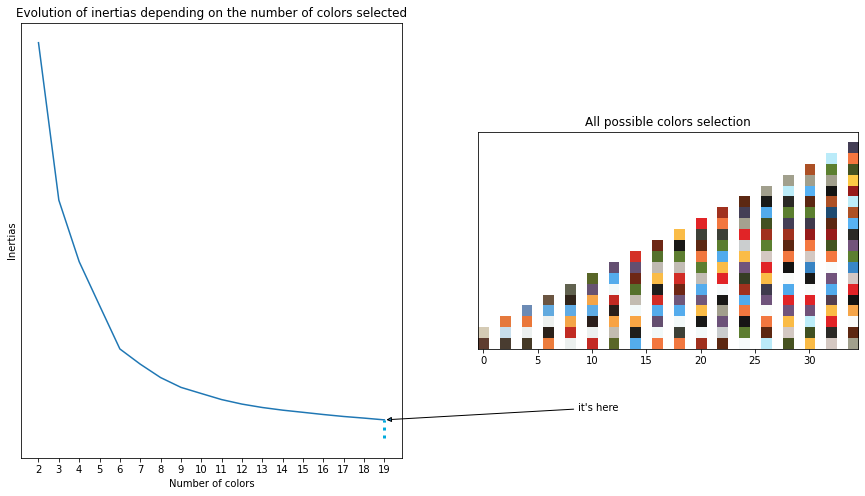

In [12]:
nb_opti_color = 19
_, ax_arr = plt.subplots(ncols=2, figsize=(15,8))
    
# Plot new_colors
nb_tested_colors = color_range[1] - color_range[0]
new_color_img = np.full(shape=(color_range[1], 2 * nb_tested_colors - 1, 3), fill_value=255)

for i, new_color in enumerate(new_colors):
    new_color_img[:new_color.shape[0], i * 2] = new_color[np.newaxis, ...]

ax_arr[1].imshow(new_color_img, origin='lower')
ax_arr[1].set_title("All possible colors selection")
ax_arr[1].set_yticklabels([]); ax_arr[1].set_yticks([])

# Plot inertias
ax_arr[0].plot(range(*color_range), inertias)
ax_arr[0].set_title("Evolution of inertias depending on the number of colors selected")
ax_arr[0].set_xlabel("Number of colors")
ax_arr[0].set_ylabel("Inertias")
ax_arr[0].set_yticklabels([]); ax_arr[0].set_yticks([])
ax_arr[0].set_xticks(range(color_range[-1]))
ax_arr[0].plot([nb_opti_color, nb_opti_color],[0, inertias[nb_opti_color - color_range[0]]],':', color = '#00aadd', lw=3)
ax_arr[0].annotate(r"it's here", xy=(nb_opti_color, inertias[nb_opti_color - color_range[0]]),
                   xytext=(nb_opti_color * 1.5, inertias[nb_opti_color - color_range[0]] * 1.5), arrowprops=dict(arrowstyle="-|>"));

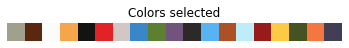

In [13]:
# Example of color sampling
nb_color = nb_opti_color

kmeans = KMeans(n_clusters=nb_color, random_state=42)
kmeans.fit(sample_pxls)
new_color_lut = kmeans.cluster_centers_.astype(np.uint8)

plt.imshow(new_color_lut[np.newaxis, :, :]); plt.axis("off"); plt.title("Colors selected");

<IPython.core.display.Javascript object>


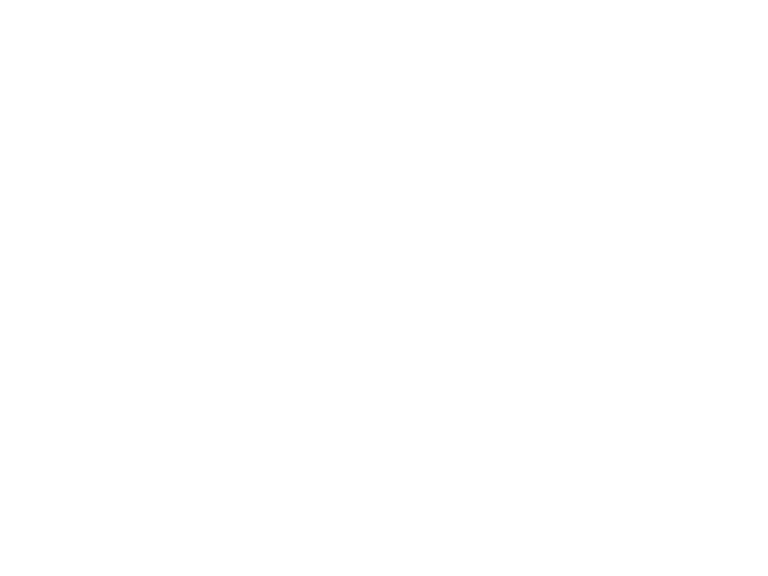

In [14]:
%matplotlib notebook

ax = plt.axes(projection="3d")

ax.scatter3D(new_color_lut[:, 0], new_color_lut[:, 1], new_color_lut[:, 2], c = new_color_lut / 255)

In [15]:
%matplotlib inline

In [16]:
color_maps = np.array([
    kmeans.predict(img[mask])
    for img, mask in zip(X, masks)
], dtype=object)

def get_recolored_img(img: np.array, mask: np.array, color_map: np.array) -> np.array:
    recolored_img = np.full_like(img, 255)
    recolored_img[mask] = new_color_lut[color_map]
    
    return recolored_img

recolored_X = np.array([
    get_recolored_img(img, mask, color_map)
    for img, mask, color_map in zip(X, masks, color_maps)
], dtype=object)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=2, ncols=5, figsize=(12,4))
    for i, (recolored_x, x) in enumerate(zip(recolored_X[Y == class_], X[Y == class_])):
        ax_arr[0, i].imshow(recolored_x)
        ax_arr[1, i].imshow(x)
        ax_arr[0, i].axis("off"); ax_arr[0, i].set_title("Recolored")
        ax_arr[1, i].axis("off"); ax_arr[1, i].set_title("Original")

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [40]:
color_maps

array([array([2, 2, 2, ..., 6, 6, 6], dtype=int32),
       array([2, 2, 2, ..., 6, 6, 6], dtype=int32),
       array([6, 6, 6, ..., 6, 6, 2], dtype=int32),
       array([2, 2, 2, ..., 2, 2, 2], dtype=int32),
       array([6, 6, 6, ..., 6, 6, 2], dtype=int32),
       array([2, 2, 2, ..., 6, 2, 2], dtype=int32),
       array([6, 6, 6, ..., 6, 6, 6], dtype=int32),
       array([2, 6, 6, ..., 9, 9, 9], dtype=int32),
       array([2, 2, 2, ..., 9, 0, 2], dtype=int32),
       array([2, 2, 6, ..., 6, 6, 6], dtype=int32),
       array([6, 6, 0, ..., 6, 6, 2], dtype=int32),
       array([6, 6, 2, ..., 0, 9, 0], dtype=int32),
       array([2, 6, 2, ..., 6, 6, 2], dtype=int32),
       array([6, 6, 0, ..., 6, 6, 2], dtype=int32),
       array([2, 6, 0, ..., 6, 6, 2], dtype=int32),
       array([ 2,  2,  2, ..., 13, 13, 13], dtype=int32),
       array([13, 13, 11, ..., 13, 13, 13], dtype=int32),
       array([13, 13, 13, ..., 13, 13, 13], dtype=int32),
       array([13, 13, 13, ..., 13, 13, 13], dt

In [17]:
np.argwhere(Y == 8)

array([[260],
       [261],
       [262],
       [263],
       [264]])

## Compute the color histograms

In [18]:
def get_hist(color_map: np.array) -> np.array:
    hist = np.bincount(color_map, minlength=nb_color)
    norm_hist = hist / hist.max()
    
    return norm_hist

color_histograms = np.array([get_hist(color_map) for color_map in color_maps], dtype=object)
color_histograms[0]

array([0.031123822341857336, 0.3240242261103634, 1.0, 0.0344885598923284,
       0.0, 0.0, 0.3799349484073576, 0.0, 0.0028600269179004036,
       0.015197397936294302, 0.01104755495737999, 0.0, 0.3825706594885599,
       0.0, 0.007907133243607, 0.0007290264692687303, 0.01256168685509197,
       0.42810677433826827, 0.009982054733064155], dtype=object)

In [19]:
colors_for_bars = new_color_lut / 255  # matplotlib colors are RGB values scaled to [0,1]

@interact(x_index=widgets.BoundedIntText(max=X.shape[0]))
def show_histograms(x_index: int) -> None:
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    plt.imshow(X[x_index])
    plt.axis('off'); plt.title("Original")
    plt.subplot(1,3,2)
    plt.imshow(recolored_X[x_index])
    plt.axis('off'); plt.title("Recolored")
    plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    plt.ylim(0, 1)
    plt.bar(range(len(color_histograms[x_index])), 
            color_histograms[x_index] / color_histograms[x_index].max(), 
            color=colors_for_bars)
    plt.xticks([]); plt.title("Histogram")
    plt.show()

interactive(children=(BoundedIntText(value=0, description='x_index', max=285), Output()), _dom_classes=('widge…

## Compute the distance matrix
Because color histograms are **very compact**, it is **very fast** to compute the distance matrix (even if the complexity is $O(n^2)$).

In [20]:
from scipy.spatial.distance import cosine

dist_mat = np.ones((len(X), len(X))) # distances will be between 0 (closest) and 1 (farthest)
for i in range(len(X)):
    for j in range(len(X)):
        dist_mat[i,j] = cosine(color_histograms[i], color_histograms[j])

Correct the diagonal to avoid getting the same result over and over: we set the distance of one element against itself to the maximum distance.

In [21]:
dist_mat[np.diag_indices_from(dist_mat)] = 1

In [22]:
idx_of_best_matches_per_row = np.argsort(dist_mat, axis=1)

## Find the best matches for each image

In [23]:
nb_images_displayed = 5

@interact(x_index=widgets.BoundedIntText(max=X.shape[0] - 1))
def show_similar_images(x_index: int) -> None:
    plt.figure(figsize=(12,8))
    nb_columns = nb_images_displayed + 1
    
    plt.subplot(1, nb_columns, 1)
    plt.imshow(recolored_X[x_index])
    plt.axis("off")
    plt.title("Original")
    
    for image_id in range(nb_images_displayed):
        idx = idx_of_best_matches_per_row[x_index, image_id]
        plt.subplot(1, nb_columns, image_id + 2)
        plt.imshow(recolored_X[idx])
        plt.axis("off")
        plt.title(f"({dist_mat[x_index, idx]: .6f})")

interactive(children=(BoundedIntText(value=0, description='x_index', max=284), Output()), _dom_classes=('widge…

A priori le nb de trous n'est pas ideal en second discriminateur. Contre-example:
- 0
- Peut-etre le 10 (jsp si 2 ou 3 trous)

Idees d'amelioration:
- Tester d'autres distances
- Reduire la "Color quantization" (a.k.a augmenter le nbr de couleurs) pour avoir une distance d'histogramme plus perinente
- Discrimineur de formes
- Tester
    - Soit d'augmenter le nombre de couleurs pour avoir un histogram + precis
    - Soit de tester des discriminateurs de formes

# Classifier base on image color histogram

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier()
cross_val_score(knn, color_histograms, Y, cv=5)

array([1.        , 0.98245614, 0.98245614, 0.98245614, 0.96491228])

In [25]:
from sklearn.svm import SVC

svc = SVC()
cross_val_score(svc, color_histograms, Y, cv=5)

array([1.        , 0.96491228, 1.        , 1.        , 0.94736842])

In [26]:
from sklearn.model_selection import cross_validate

dict_ = cross_validate(knn, color_histograms, Y, cv=5, return_estimator=True)
dict_["test_score"]

array([1.        , 0.98245614, 0.98245614, 0.98245614, 0.96491228])

In [27]:
best_knn = dict_["estimator"][1]

In [28]:
dict_svc = cross_validate(svc, color_histograms, Y, cv=5, return_estimator=True)
dict_svc["test_score"]

array([1.        , 0.96491228, 1.        , 1.        , 0.94736842])

In [29]:
best_svc = dict_svc["estimator"][1]

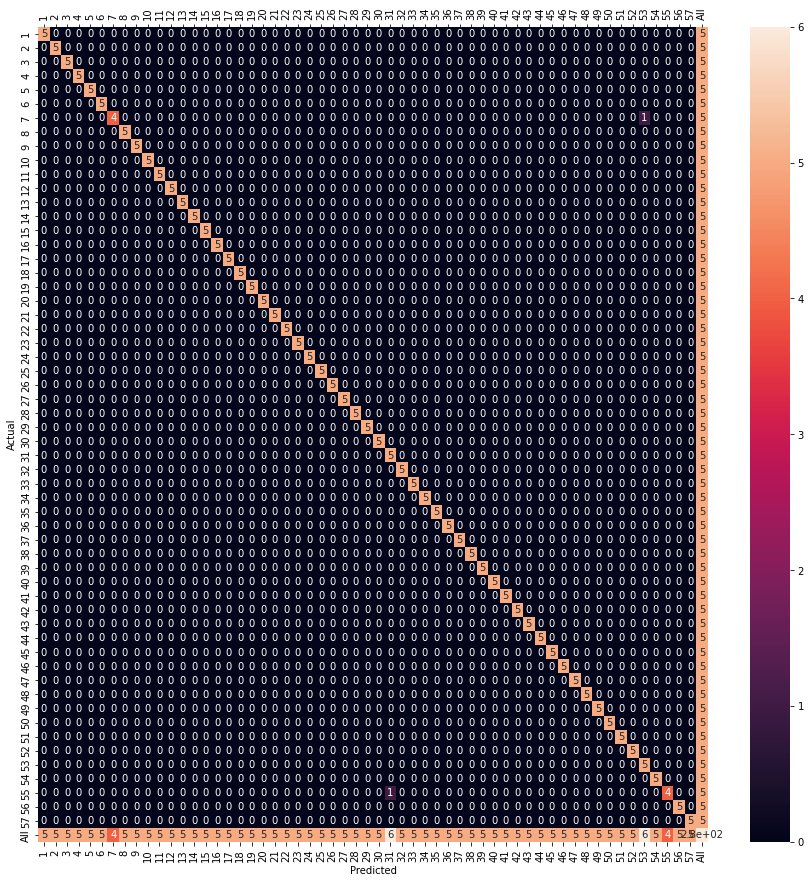

In [30]:
import pandas as pd
import seaborn as sn

def print_confusion_matrix(predicted: np.array, actual: np.array) -> None:
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, bottom=True, top=True, labeltop=True)
    sn.heatmap(confusion_matrix, annot=True, vmax=np.max(confusion_matrix.max()[:-1]))
    plt.show()
    
plt.rcParams["figure.figsize"] = (15,15)
print_confusion_matrix(best_knn.predict(color_histograms), Y)

On voit la class 6 (Le bon homme de neige) est confondu avec les class 12 et 32, respectivement le Fantome et le Crayon.
Ce qui est logique comme ils ont tous les 3 des couleurs tres similaires.

In [31]:
from sklearn.metrics import precision_score

precision_score(Y, best_knn.predict(color_histograms), average='macro')

0.9941520467836257

### Frequency classification attempt

We wanted to make an extra classifier using the frequency of an image so we tried with the FFT and DCT algorithms.

In [47]:
fft_frequences = np.array([
    np.fft.fft2(img)
    for img, mask in zip(X, masks)
], dtype=object)
fft_frequences

array([array([[[ 1.87795000e+05  +0.j        ,  7.30000000e+01 -12.12435565j,
                 7.30000000e+01 +12.12435565j],
               [ 3.94243360e+02  -3.89826736j, -7.11731670e+01 +16.6642968j ,
                -7.43548274e+01  -7.48053361j],
               [-3.91978574e+02  +7.73925183j,  6.88867859e+01 -21.06742321j,
                 7.52288522e+01  +2.76663154j],
               ...,
               [ 3.88220992e+02 +11.46627695j, -7.56170102e+01  -1.98298139j,
                -6.61568703e+01 -25.30195866j],
               [-3.91978574e+02  -7.73925183j,  7.52288522e+01  -2.76663154j,
                 6.88867859e+01 +21.06742321j],
               [ 3.94243360e+02  +3.89826736j, -7.43548274e+01  +7.48053361j,
                -7.11731670e+01 -16.6642968j ]],

              [[ 1.77762000e+05  +0.j        ,  8.31000000e+02-368.92682201j,
                 8.31000000e+02+368.92682201j],
               [ 1.02768503e+04 +33.28238616j, -8.10068366e+02+385.83390114j,
                -8

In [48]:
@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, x in enumerate(fft_frequences[Y == class_]):
        fshift = np.fft.fftshift(x)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        #ax_arr[i].imshow(abs(x).astype('uint8'))
        ax_arr[i].imshow(abs(magnitude_spectrum).astype('uint8'), cmap='gray')

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [131]:
def get_dct(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imf = np.float32(img)/255.0
    dst = cv2.dct(imf)
    return np.uint8(dst)*255.0


dcts = np.array([get_dct(img) for img in X], dtype=object)
dcts

array([array([[45645.,     0., 65025., ...,     0.,     0.,     0.],
              [62985.,   255.,   765., ...,     0.,     0.,     0.],
              [64515.,     0.,  8415., ...,     0.,     0.,     0.],
              ...,
              [    0.,     0.,     0., ...,     0.,     0.,     0.],
              [    0.,     0.,     0., ...,     0.,     0.,     0.],
              [    0.,     0.,     0., ...,     0.,     0.,     0.]]),
       array([[40800.,  2295., 64770., ...,     0.,     0.,     0.],
              [    0., 65025.,     0., ...,     0.,     0.,     0.],
              [65025., 64515.,  8160., ...,     0.,     0.,     0.],
              ...,
              [    0.,     0.,     0., ...,     0.,     0.,     0.],
              [    0.,     0.,     0., ...,     0.,     0.,     0.],
              [    0.,     0.,     0., ...,     0.,     0.,     0.]]),
       array([[41565., 63240., 64770., ...,     0.,     0.,     0.],
              [65025., 65025.,     0., ...,     0.,     0.,  

In [84]:
@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    class_dcts = dcts[Y == class_]
    for i, x in enumerate(masks[Y == class_]):
        ax_arr[i].imshow(x, cmap='gray')
        ax_arr[i].axis('off')
        ax_arr[i].set_title(np.round(class_dcts[i][0][:3],2))

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [109]:
def diagonalOrder(matrix, size):
    row, col = matrix.shape
    diag = []
    for line in range(1, (row + col)):
        if len(diag) >= size:
            break
        start_col = max(0, line - row)
        count = min(line, (col - start_col), row)
 
        for j in range(0, count):
            if len(diag) >= size:
                return diag
            diag.append(matrix[min(row, line) - j - 1]
                        [start_col + j])
    return diag

a = np.arange(9).reshape(3,3)
print(a)
diagonalOrder(a, 3)

[[0 1 2]
 [3 4 5]
 [6 7 8]]


[0, 3, 1]

In [130]:
dct_coeffs = np.array([ diagonalOrder(dct, 100) for dct in dcts], dtype=object)
cross_val_score(knn, dct_coeffs, Y, cv=5)

array([0.33333333, 0.26315789, 0.31578947, 0.29824561, 0.33333333])

### DCT evaluation

We can see that comparing the coefficient of the Discret Cosine Transformation of our Images are not a strong feature to compare our images. This is because the DCT is not scale invariant nor rotation invariant. 

In [125]:
@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    class_coeffs = dct_coeffs[Y == class_]
    for i, x in enumerate(masks[Y == class_]):
        ax_arr[i].imshow(x, cmap='gray')
        ax_arr[i].axis('off')
        ax_arr[i].set_title(str(class_coeffs[i][:2]))

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…